Input data:
-	Artificial data as created by Cole

Exploratory:
-	Plot the data
-	Plot a Lomb-Scargle periodogram

Processing:
-	Compose a Gaussian Process from a reasonable guess of kernels
-	Learn the hyperparameters of each kernels by search
-	Substract the model from the data
-	Test that the remainder is white noise(?)
-	Predict gaps using the model?

Output:
-	Plot the data
-	Take X samples of final model and visualize
-	Show the model applied to the data with confidence intervals

Adapted in notebook GP_S+L 3:
- Use data file sim_noisy_pulse.lc
- Add an uncorrelated error measurement component

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

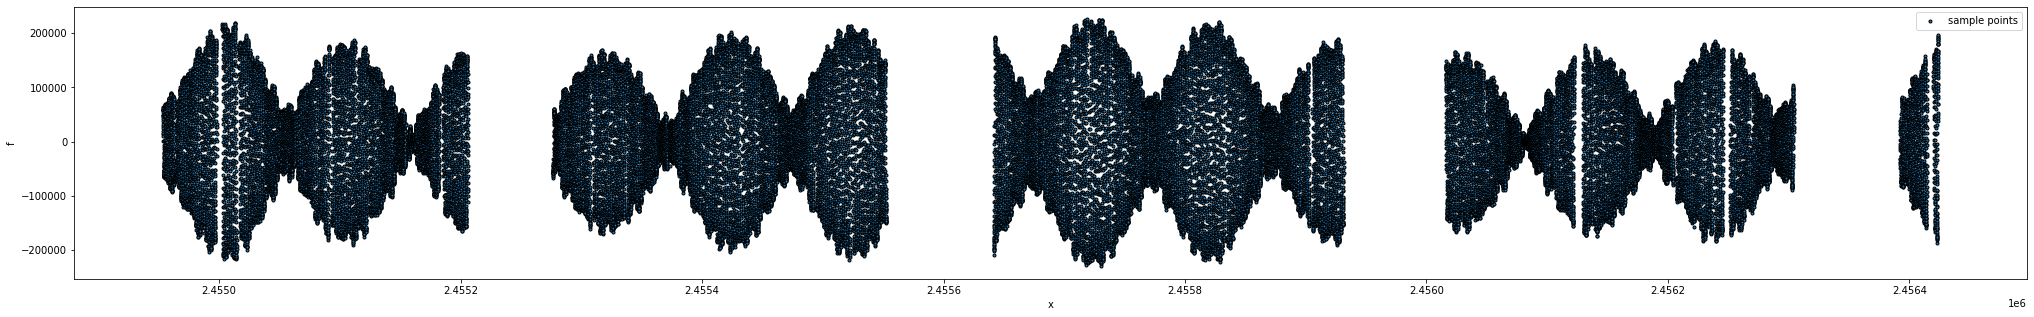

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [18]:
# This library becomes unstable at N=15125
# works: N=15800 
# works: N=24040
# Doesn't work: # X.shape[0]
# works: N=36040
N=46040

In [19]:
train_x=X[:N]
train_y=Y[:N]

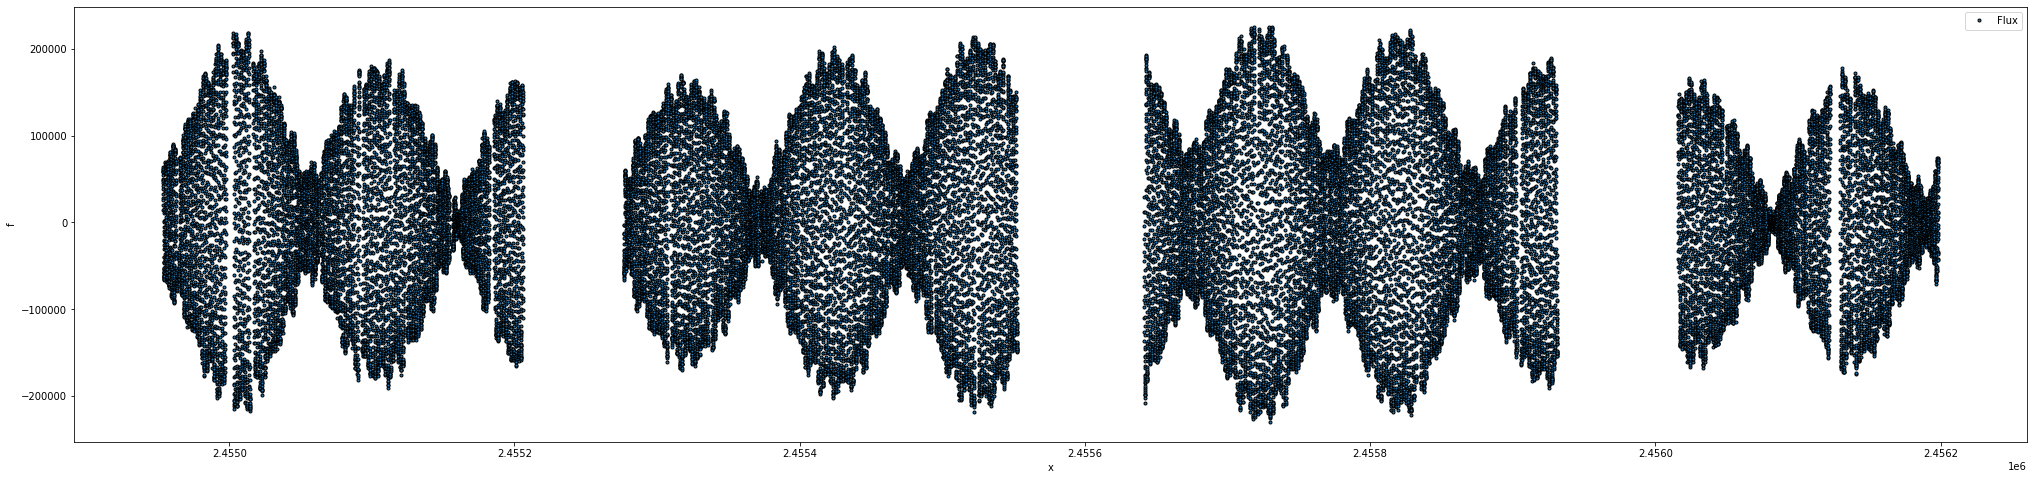

In [20]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [21]:
# Predict evenly spaced points on our time-axis
tsmooth = np.linspace(train_x.min(),train_x.max(),N)

t = train_x
y = train_y
yerr = 0

In [22]:
# Initialize the S+LEAF model
# One stochastically-driven harmonic oscillator
## One Uncorrelated measurement errors (yerr)
cov_matrix = cov.Cov(t,
   err = term.Error(yerr),
   sho = term.SHOKernel(sig=-1, P0=1.7474, Q=8019.36505))

# For higher N, the kernel period is more like:
# sho = term.SHOKernel(sig=-1, P0=0.3569, Q=8019.36505)
# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# Define the function to minimize
def negloglike(x, y, cov_matrix):
   cov_matrix.set_param(x)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

# Fit
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(y, cov_matrix))

# We now use S+LEAF to predict the missing data
cov_matrix.set_param(xbest)
mu, var = cov_matrix.conditional(y, tsmooth, calc_cov='diag')

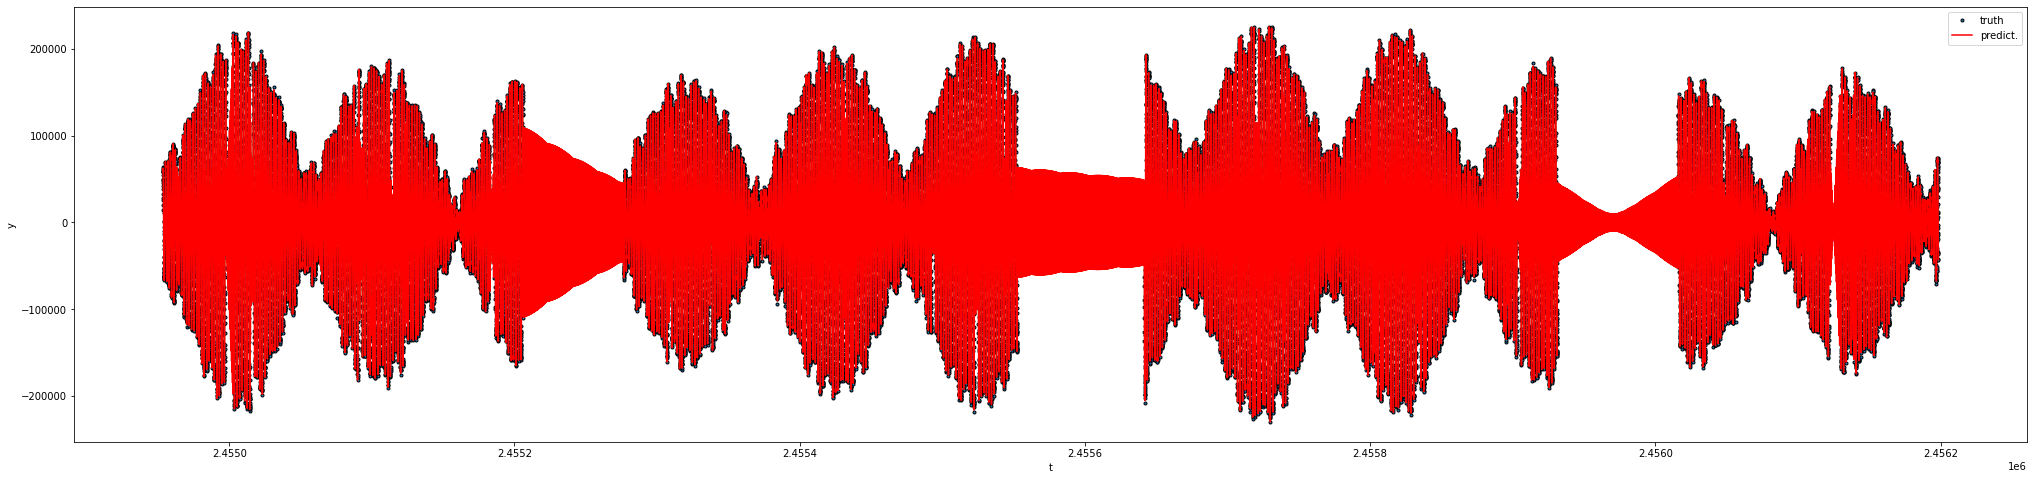

In [23]:
# Plot
plt.figure(figsize=(35, 8))
plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black", label='truth')
#plt.plot(tsmooth, ysignal, 'r', label='truth')
#plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
plt.fill_between(tsmooth, mu-np.sqrt(var), mu+np.sqrt(var), color='g', alpha=0.5)
plt.plot(tsmooth, mu, 'r', label='predict.')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

In [24]:
cov_matrix.param

['sho.sig', 'sho.P0', 'sho.Q']

In [25]:
sho_kern = cov_matrix.kernel['sho']
sho_kern

In [26]:
cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

(-28.449690301297018, 0.32410353407474063, 8019.354050649422)

## RMSE

In [27]:
mu, var = cov_matrix.conditional(train_y, train_x, calc_cov='diag')

np.sqrt(np.nanmean((mu-train_y)**2))

5.793249643738631e-05

RMSE per x

In [28]:
np.sqrt(np.nanmean((mu-train_y)**2))/N

1.258307915668686e-09